# Question 14

In [124]:
import json
import datetime,time
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import time
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

In [128]:
train_path = "../../projects/project_5/ECE219_tweet_data/"

train_files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
# train_files = ["tweets_#gopatriots.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

In [100]:
test_path = "../../projects/project_5/ECE219_tweet_test/"

test_files = [["sample0_period1.txt", "sample0_period2.txt", "sample0_period3.txt"], \
              ["sample1_period1.txt", "sample1_period2.txt", "sample1_period3.txt"], \
              ["sample2_period1.txt", "sample2_period2.txt", "sample2_period3.txt"]]

#### Prepare for data

In [101]:
def transfer_time(data_raw,time_type):
    """
    Given UNIX time stored in data_raw["time"], return either hour index or minute index
    and store in "time" depending on the period require.
    """
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','tweets','retweets','followers','mentioned',\
                                                'media','active','author','favourites_count','title'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)               

    # calculate hour index and minute index from time
    if time_type == 'hour':
        hour_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)  
            hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)                             
        pddata_raw['time'] = hour_accu
    elif time_type == 'minute':
        minu_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)                    
            minu_accu.append((((p.month-1)*31+p.day-14)*24 + (p.hour-0))*12 + p.minute//5)             
        pddata_raw['time'] = minu_accu    
    else:
        print("Invalid time type")
        
    return pddata_raw

In [102]:
def six_times_window(df,df_y):
    a = df.values.tolist()
    b = []
    for i in range(len(a)-4):
        tmp = []
        for j in range(i,i+5):
            tmp += a[j]
        b.append(tmp)        
    return pd.DataFrame(b),df_y[4:]

In [103]:
def generate_df(pddata_raw):
    """
    Create a new dataframe with desired form
    """
    df = pd.DataFrame([],columns=['time unit','tweets','retweets','followers sum','followers max',\
                                  'mentioned','media','active','author','favourites_count','title'])
    
    col = pddata_raw.columns.get_loc('time')
    df['time unit'] = range(int(pddata_raw.iloc[len(pddata_raw.index)-1,col] - pddata_raw.iloc[0,col]+1))

    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['mentioned'] = pddata_raw.groupby("time")['mentioned'].sum()
    df['media'] = pddata_raw.groupby("time")['media'].sum()
    df['active'] = pddata_raw.groupby("time")['active'].mean()  
    df['author'] = pddata_raw.groupby("time")['author'].nunique() # count number of not-repeating authors    
    df['favourites_count'] = pddata_raw.groupby("time")['favourites_count'].sum()
    df['title'] = pddata_raw.groupby("time")['title'].mean()
            
    # reset index of df
    df = df.fillna(0).reset_index(drop=True)
    
    return df

In [104]:
def parse_dataset(path,files):
    """
    Parse x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Parse y of dataset as number of tweets in the next hour.
    """
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r') :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']             
            ment = len(a['tweet']['entities']['user_mentions'])        
            medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
            hist_tw = a['tweet']['user']["statuses_count"]
            hist_yr = a['tweet']['user']['created_at'][-4:]
            acti = hist_tw/(2015-float(hist_yr)+1) 
            auth = a['author']['name']
            favo = a['tweet']['user']['favourites_count']
            titl = len(a['title'])

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)    
            row_tmp.append(ment) 
            row_tmp.append(medi) 
            row_tmp.append(acti)  
            row_tmp.append(auth)
            row_tmp.append(favo)
            row_tmp.append(titl)

            # assign to 3 periods
            if citation_date < start_time:
                data_raw[0].append(row_tmp)
            elif citation_date < end_time:
                data_raw[1].append(row_tmp)
            else:
                data_raw[2].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_1['time'] = pddata_raw_1['time'] - pddata_raw_1.loc[0,'time']
    
    pddata_raw_2 = transfer_time(data_raw[1],'minute')
    pddata_raw_2['time'] = pddata_raw_2['time'] - pddata_raw_2.loc[0,'time']

    pddata_raw_3 = transfer_time(data_raw[2],'hour')  
    pddata_raw_3['time'] = pddata_raw_3['time'] - pddata_raw_3.loc[0,'time']
    
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,1].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    
    df_2 = generate_df(pddata_raw_2)
    df_y_2 = df_2.iloc[1:,1].reset_index(drop=True)
    df_2 = df_2[:len(df_y_2)]
   
    df_3 = generate_df(pddata_raw_3)
    df_y_3 = df_3.iloc[1:,1].reset_index(drop=True)
    df_3 = df_3[:len(df_y_3)]
    
    return (df_1.iloc[:,1:],df_y_1), (df_2.iloc[:,1:],df_y_2), (df_3.iloc[:,1:],df_y_3)

#### Train model with aggregated data, test model with test files

In [105]:
def parse_testdata(path,file,time_type):
    """
    Parse x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    """

    # extract raw features
    data_raw = []
    for line in open(path + file, 'r') :
        row_tmp = []
        a = json.loads(line)
        time = a['citation_date']
        tweet = 1        
        retweet = a['metrics']['citations']['total']
        foll = a['author']['followers']             
        ment = len(a['tweet']['entities']['user_mentions'])        
        medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
        hist_tw = a['tweet']['user']["statuses_count"]
        hist_yr = a['tweet']['user']['created_at'][-4:]
        acti = hist_tw/(2015-float(hist_yr)+1) 
        auth = a['author']['name']
        favo = a['tweet']['user']['favourites_count']
        titl = len(a['title'])
        
        # append to list
        row_tmp.append(time)
        row_tmp.append(tweet)                
        row_tmp.append(retweet)
        row_tmp.append(foll)    
        row_tmp.append(ment) 
        row_tmp.append(medi) 
        row_tmp.append(acti)  
        row_tmp.append(auth)
        row_tmp.append(favo)
        row_tmp.append(titl)        
        data_raw.append(row_tmp)        

    # generate raw pandas dataframe
    pddata_raw = transfer_time(data_raw,time_type)
    pddata_raw['time'] = pddata_raw['time'] - pddata_raw.loc[0,'time']

    # generate df and df_y for each time slot
    df = generate_df(pddata_raw)      
    df_y = df.iloc[1:,1].reset_index(drop=True)
    df = df[:len(df_y)]
            
    return df.iloc[:,1:],df_y

In [106]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**1/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()   

In [140]:
def train_lr(train_path, train_files):
    """
    This function gets train data and train using a linear regression model
    """    
    (df_1,df_y_1),(df_2,df_y_2),(df_3,df_y_3) = parse_dataset(train_path, train_files)

    df_1,df_y_1  = six_times_window(df_1,df_y_1)
    df_2,df_y_2  = six_times_window(df_2,df_y_2)
    df_3,df_y_3  = six_times_window(df_3,df_y_3)    

#     # linear regressor
#     reg_1 = LinearRegression()
#     reg_2 = LinearRegression()
#     reg_3 = LinearRegression()

#     # random forest regressor
#     reg_1 = RandomForestRegressor(oob_score=True,n_estimators=400,max_depth=20,min_samples_leaf=2,min_samples_split=10, bootstrap=True,max_features='sqrt',random_state=42)
#     reg_2 = RandomForestRegressor(oob_score=True,n_estimators=2000,max_depth=20,min_samples_leaf=4,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
#     reg_3 = RandomForestRegressor(oob_score=True,n_estimators=400,max_depth=20,min_samples_leaf=4,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)

   # neural network regressor
    scaler_1 = StandardScaler()
    scaler_1.fit(df_1)
    df_1 = scaler_1.transform(df_1)
    reg_1 = MLPRegressor(hidden_layer_sizes=(500,1000,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42)
    reg_1.fit(df_1,df_y_1)
    scaler_2 = StandardScaler()
    scaler_2.fit(df_2)
    df_2 = scaler_2.transform(df_2)
    reg_2 = MLPRegressor(hidden_layer_sizes=(500,1000,1000,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
    reg_2.fit(df_2,df_y_2)    
    scaler_3 = StandardScaler()
    scaler_3.fit(df_3)
    df_3 = scaler_3.transform(df_3)
    reg_3 = MLPRegressor(hidden_layer_sizes=(500,1000,500,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 

#   # gradient boosting regressor
#     reg_1 = GradientBoostingRegressor(n_estimators=20,max_depth=20,min_samples_leaf=2,min_samples_split=10, max_features='sqrt',random_state=42)    
#     reg_2 = GradientBoostingRegressor(n_estimators=40,max_depth=20,min_samples_leaf=4,min_samples_split=2, max_features='sqrt',random_state=42)
#     reg_3 = GradientBoostingRegressor(n_estimators=20,max_depth=20,min_samples_leaf=4,min_samples_split=2, max_features='sqrt',random_state=42)
    
    reg_1.fit(df_1,df_y_1)    
    reg_2.fit(df_2,df_y_2)     
    reg_3.fit(df_3,df_y_3) 

    plot_recipe(df_y_1, reg_1.predict(df_1))
    plot_recipe(df_y_2, reg_2.predict(df_2))
    plot_recipe(df_y_3, reg_3.predict(df_3))
    
    return (reg_1, reg_2, reg_3)

In [108]:
def test_lr(test_path, test_file, regs):
    """
    This function gets test data and test with a linear regression model
    """    
    reg_1, reg_2, reg_3 = regs
    
    df_1, df_y_1 = parse_testdata(test_path, test_file[0],'hour')
    df_2, df_y_2 = parse_testdata(test_path, test_file[1],'minute')
    df_3, df_y_3 = parse_testdata(test_path, test_file[2],'hour')
    
    df_1,df_y_1  = six_times_window(df_1,df_y_1)
    df_2,df_y_2  = six_times_window(df_2,df_y_2)
    df_3,df_y_3  = six_times_window(df_3,df_y_3)   
      
    pred_y_1 = reg_1.predict(df_1)     
    print("time period 1 predicted tweet: ",pred_y_1[0], " true value: ", df_y_1.iloc[0])

    pred_y_2 = reg_2.predict(df_2)     
    print("time period 2 predicted tweet: ",pred_y_2[0], " true value: ", df_y_2.iloc[0])

    pred_y_3 = reg_3.predict(df_3)     
    print("time period 3 predicted tweet: ",pred_y_3[0], " true value: ", df_y_3.iloc[0])
    
    return (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3)

## Results

#### random forest regressor

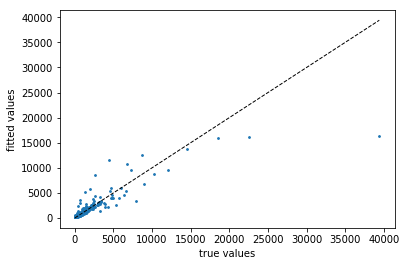

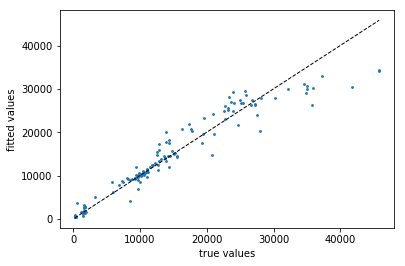

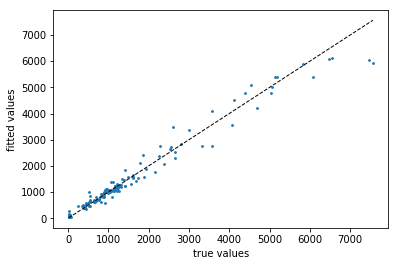

('time period 1 predicted tweet: ', 372.14071365827795, ' true value: ', 120)
('time period 2 predicted tweet: ', 4797.610513555973, ' true value: ', 1123)
('time period 3 predicted tweet: ', 121.55599824827942, ' true value: ', 87)
('time period 1 predicted tweet: ', 780.6218771208372, ' true value: ', 846)
('time period 2 predicted tweet: ', 4367.4307748957635, ' true value: ', 903)
('time period 3 predicted tweet: ', 105.26940136252634, ' true value: ', 46)
('time period 1 predicted tweet: ', 292.28023688913214, ' true value: ', 61)
('time period 2 predicted tweet: ', 718.5128505312981, ' true value: ', 28)
('time period 3 predicted tweet: ', 173.36268813478196, ' true value: ', 43)


In [139]:
regs = train_lr(train_path, train_files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(test_path, file, regs)

#### gradient boosting regressor

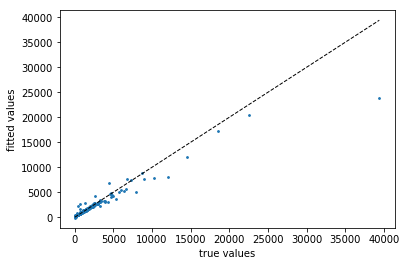

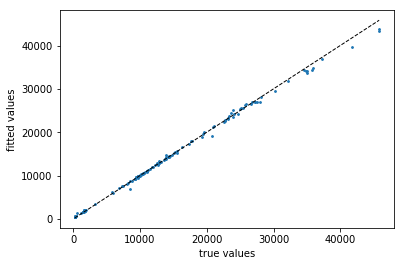

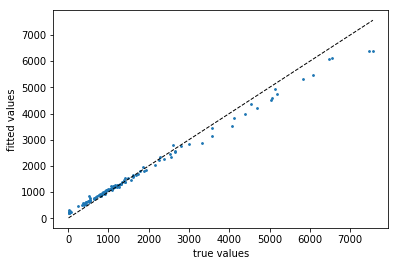

('time period 1 predicted tweet: ', 448.6346445148513, ' true value: ', 120)
('time period 2 predicted tweet: ', 5460.919984018541, ' true value: ', 1123)
('time period 3 predicted tweet: ', 331.28828422970844, ' true value: ', 87)
('time period 1 predicted tweet: ', 925.7271754250297, ' true value: ', 846)
('time period 2 predicted tweet: ', 4933.9827542297335, ' true value: ', 903)
('time period 3 predicted tweet: ', 318.99010795561117, ' true value: ', 46)
('time period 1 predicted tweet: ', 347.2618200406004, ' true value: ', 61)
('time period 2 predicted tweet: ', 1157.7254432768461, ' true value: ', 28)
('time period 3 predicted tweet: ', 375.8245452832703, ' true value: ', 43)


In [137]:
regs = train_lr(train_path, train_files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(test_path, file, regs)

#### neural network regressor

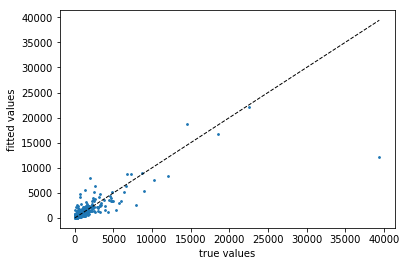

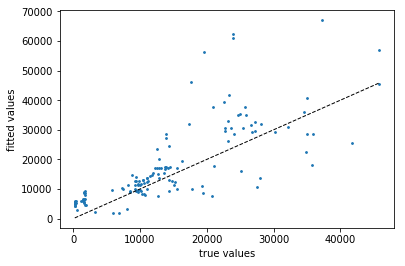

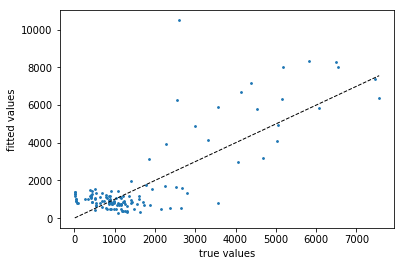

('time period 1 predicted tweet: ', 1089236381.9923224, ' true value: ', 120)
('time period 2 predicted tweet: ', 92538102022.8897, ' true value: ', 1123)
('time period 3 predicted tweet: ', 742634917.4587606, ' true value: ', 87)
('time period 1 predicted tweet: ', 1601947500.8707156, ' true value: ', 846)
('time period 2 predicted tweet: ', 32831561561.137592, ' true value: ', 903)
('time period 3 predicted tweet: ', 2179485658.567296, ' true value: ', 46)
('time period 1 predicted tweet: ', 536611452.2321525, ' true value: ', 61)
('time period 2 predicted tweet: ', 2743649669.2162323, ' true value: ', 28)
('time period 3 predicted tweet: ', 2407143163.0860634, ' true value: ', 43)


In [141]:
regs = train_lr(train_path, train_files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(test_path, file, regs)

#### linear regressor

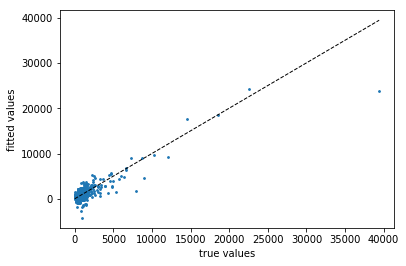

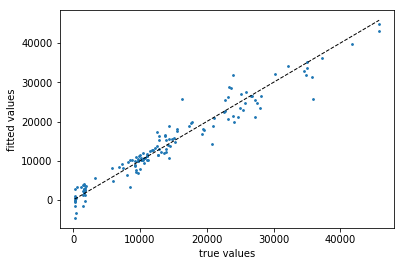

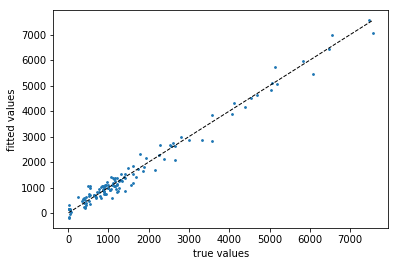

('time period 1 predicted tweet: ', 417.60483363000003, ' true value: ', 120)
('time period 2 predicted tweet: ', 1938.9533268040032, ' true value: ', 1123)
('time period 3 predicted tweet: ', 148.31441664982867, ' true value: ', 87)
('time period 1 predicted tweet: ', 1528.850160068254, ' true value: ', 846)
('time period 2 predicted tweet: ', 5063.073099679808, ' true value: ', 903)
('time period 3 predicted tweet: ', -336.8627428940508, ' true value: ', 46)
('time period 1 predicted tweet: ', 1021.8649206535056, ' true value: ', 61)
('time period 2 predicted tweet: ', 9200.177079708374, ' true value: ', 28)
('time period 3 predicted tweet: ', 334.5859724971442, ' true value: ', 43)


In [109]:
regs = train_lr(train_path, train_files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(test_path, file, regs)